In [3]:
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
import numpy as np
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

BATCH_SIZE = 64
EPOCH_SIZE = 64

In [4]:
# transfer learning - load pre-trained vgg and replace its head
vgg = tf.keras.applications.VGG16(input_shape=[128, 128, 3], include_top=False, weights='imagenet')
x = Flatten()(vgg.output)
x = Dense(3, activation='sigmoid')(x)
model1 = Model(vgg.input, x)
model1.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001))
# plot the model
plot_model(model1, "first_model.png",show_shapes=True,expand_nested=False)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


C:\Users\mavbe\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


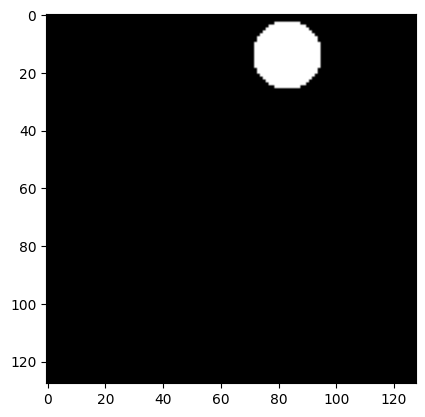

In [5]:
from matplotlib.patches import Circle

def synthetic_gen(batch_size=64):
  # enable generating infinite amount of batches
  while True:
      # generate black images in the wanted size
      X = np.zeros((batch_size, 128, 128, 3))
      Y = np.zeros((batch_size, 3))
      # fill each image
      for i in range(batch_size):
        x = np.random.randint(8,120)
        y = np.random.randint(8,120)
        a = min(128 - max(x,y), min(x,y))
        r = np.random.randint(4,a)
        for x_i in range(128):
          for y_i in range(128):
            if ((x_i - x)**2) + ((y_i - y)**2) < r**2:
              X[i, x_i, y_i,:] = 1
        Y[i,0] = (x-r)/128.
        Y[i,1] = (y-r)/128.
        Y[i,2] = 2*r / 128.
      yield X, Y

# sanity check - plot the images
x,y = next(synthetic_gen())
plt.imshow(x[0])

In [6]:
# needs steps per epoch since the generator is infinite
model1.fit_generator(synthetic_gen(),steps_per_epoch=EPOCH_SIZE,epochs=5)

C:\Users\mavbe\AppData\Local\Temp\ipykernel_78328\3760285612.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model1.fit_generator(synthetic_gen(),steps_per_epoch=EPOCH_SIZE,epochs=5)


Epoch 1/5
64/64 [==============================] - 386s 6s/step - loss: 0.5777
Epoch 2/5
64/64 [==============================] - 394s 6s/step - loss: 0.4927
Epoch 3/5
64/64 [==============================] - 382s 6s/step - loss: 0.4940
Epoch 4/5
64/64 [==============================] - 407s 6s/step - loss: 0.4906
Epoch 5/5
64/64 [==============================] - 402s 6s/step - loss: 0.4935


2/2 [==============================] - 2s 714ms/step


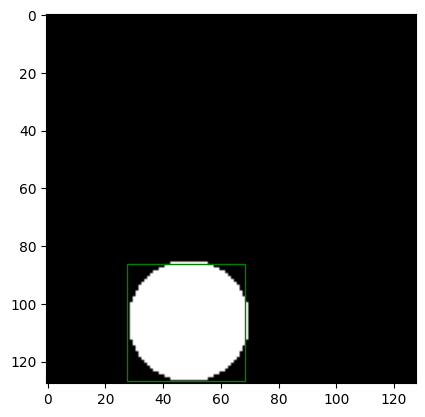

In [7]:
from matplotlib.patches import Rectangle

# given image and a label, plots the image + rectangle
def plot_pred(img,p):
  fig, ax = plt.subplots(1)
  ax.imshow(img)
  rect = Rectangle(xy=(p[1]*128,p[0]*128),width=p[2]*128, height=p[2]*128, linewidth=1,edgecolor='g',facecolor='none')
  ax.add_patch(rect)
  plt.show()


# generate new image
x, _ = next(synthetic_gen())
# predict
pred = model1.predict(x)
# examine 1 image
im = x[0]
p = pred[0]
plot_pred(im,p)

In [8]:
print(p)

[0.6740293  0.21625155 0.31702027]


In [6]:
from PIL import Image
from matplotlib.patches import Circle

cat_pil = Image.open("cat.png")
cat_pil = cat_pil.resize((64,64))
cat = np.asarray(cat_pil)

def cat_gen(batch_size=64):
  # enable generating infinite amount of batches
  while True:
      # generate black images in the wanted size
      X = np.zeros((batch_size, 128, 128, 3))
      Y = np.zeros((batch_size, 3))
      # fill each image
      for i in range(batch_size):
        # resize the cat
        size = np.random.randint(32,64)
        temp_cat = cat_pil.resize((size,size))
        cat = np.asarray(temp_cat) / 255.
        cat_x, cat_y, _ = cat.shape
        # create a blank background image
        bg = Image.new('RGB', (128, 128))
        # generate 
        x1 = np.random.randint(1,128 - cat_x)
        y1 = np.random.randint(1,128 - cat_y)
        # paste the cat over the image
        bg.paste(temp_cat, (x1, y1))
        cat = np.asarray(bg) / 255. # transform into a np array
        X[i] = cat

        Y[i,0] = x1/128.
        Y[i,1] = y1/128.
        Y[i,2] = cat_x / 128.
      yield X, Y

# plot the images
x,y = next(cat_gen())
plt.imshow(x[0])

FileNotFoundError: [Errno 2] No such file or directory: 'cat.png'

In [ ]:
# transfer learning - load pre-trained vgg and replace its head
vgg = tf.keras.applications.VGG16(input_shape=[128, 128, 3], include_top=False, weights='imagenet')
x = Flatten()(vgg.output)
x = Dense(3, activation='sigmoid')(x)
model2 = Model(vgg.input, x)
model2.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001))
# plot the model
plot_model(model2, "second_model.png",show_shapes=True)

# needs steps per epoch since the generator is infinite
model2.fit_generator(cat_gen(),steps_per_epoch=EPOCH_SIZE,epochs=5)

from matplotlib.patches import Rectangle

# given image and a label, plots the image + rectangle
def plot_pred(img,p):
  fig, ax = plt.subplots(1)
  ax.imshow(img)
  rect = Rectangle(xy=(p[0]*128,p[1]*128),width=p[2]*128, height=p[2]*128, linewidth=1,edgecolor='g',facecolor='none')
  ax.add_patch(rect)
  plt.show()


# generate new image
x, _ = next(cat_gen())
# predict
pred = model2.predict(x)
# examine 1 image
im = x[0]
p = pred[0]
plot_pred(im,p)

In [ ]:
from PIL import Image

cat_pil = Image.open("cat.png")
cat_pil = cat_pil.resize((64,64))
cat = np.asarray(cat_pil)

def natural_cat_gen(batch_size=64):
  # enable generating infinite amount of batches
  while True:
      # generate black images in the wanted size
      X = np.zeros((batch_size, 128, 128, 3))
      Y = np.zeros((batch_size, 3))
      # fill each image
      for i in range(batch_size):
        # resize the cat
        size = np.random.randint(32,64)
        temp_cat = cat_pil.resize((size,size))
        cat = np.asarray(temp_cat) / 255.
        cat_x, cat_y, _ = cat.shape
        # background image
        bg_name = f'bg{np.random.randint(1,4)}.jpg'
        bg = Image.open(bg_name)

        x1 = np.random.randint(1,128 - cat_x)
        y1 = np.random.randint(1,128 - cat_y)
        h = cat_x
        w = cat_y
        # draw the cat over the selected background image
        bg.paste(temp_cat, (x1, y1),mask=temp_cat)
        cat = np.asarray(bg) / 255.
        X[i] = cat

        Y[i,0] = x1/128.
        Y[i,1] = y1/128.
        Y[i,2] = cat_x / 128.
      yield X, Y

# sanity check - plot the images
x,y = next(natural_cat_gen())
plt.imshow(x[0])

In [ ]:
# define a mode
# transfer learning - load pre-trained vgg and replace its head
vgg = tf.keras.applications.VGG16(input_shape=[128, 128, 3], include_top=False, weights='imagenet')
x = Flatten()(vgg.output)
x = Dense(3, activation='sigmoid')(x)
model3 = Model(vgg.input, x)
model3.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001))
# plot the model
plot_model(model3, "third_model.png",show_shapes=True)

# train it
# needs steps per epoch since the generator is infinite
model3.fit_generator(natural_cat_gen(),steps_per_epoch=EPOCH_SIZE,epochs=5)

from matplotlib.patches import Rectangle

# given image and a label, plots the image + rectangle
def plot_pred(img,p):
  fig, ax = plt.subplots(1)
  ax.imshow(img)
  rect = Rectangle(xy=(p[0]*128,p[1]*128),width=p[2]*128, height=p[2]*128, linewidth=1,edgecolor='r',facecolor='none')
  ax.add_patch(rect)
  plt.show()


# generate new image
x, _ = next(natural_cat_gen())
# predict
pred = model3.predict(x)
# examine 1 image
im = x[0]
p = pred[0]
plot_pred(im,p)